In [22]:
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

In [3]:
## Load dataset
dataset = NWBDataset("~/data/000128/sub-Jenkins/", "*train", split_heldout=False)

In [7]:
dataset.resample(5)

In [25]:
# Find unique conditions
conds = dataset.trial_info.set_index(["trial_type", "trial_version"]).index.unique().tolist()
print(conds[:5])
print(f"Number of unique conditions: {len(conds)}")

[(25, 2), (3, 1), (22, 1), (29, 2), (21, 0)]
Number of unique conditions: 108


  0%|          | 0/108 [00:00<?, ?it/s]

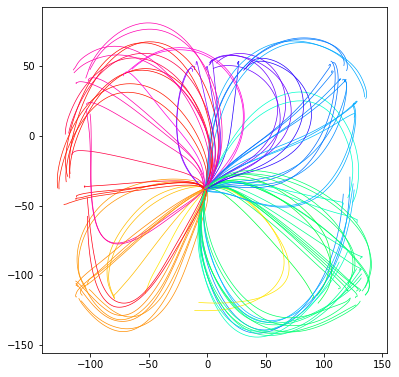

In [26]:
# Plot averaged reaches for each of the 108 unique conditions
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for cond in tqdm(conds):
    # boolean mask for trials of same type
    mask = np.all(dataset.trial_info[['trial_type', 'trial_version']] == cond, axis=1)
    # aggregate / align the different trials of this condition type (based on mask)
    trial_data = dataset.make_trial_data(align_field="move_onset_time", align_range=(-50, 450), ignored_trials=(~mask))
    # extract the average hand_pos across these trials of the same type
    traj = trial_data.groupby('align_time')[[('hand_pos', 'x'), ('hand_pos', 'y')]].mean().to_numpy()
    # determine reach angle for color
    active_target = dataset.trial_info[mask].target_pos.iloc[0][dataset.trial_info[mask].active_target.iloc[0]]
    reach_angle = np.arctan2(*active_target[::-1])
    # plot reach
    ax.plot(traj[:, 0], traj[:, 1], linewidth=0.7, color=plt.cm.hsv(reach_angle / (2*np.pi) + 0.5))
